In [17]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

In [25]:
# Futures contract on the AMZN stock prices:
# This is the continuous chain of the futures contracts that are 1 month to expiration
amzn_futures = pd.read_csv(
    Path("../Resources/amzn_data.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
amzn_futures.head()

,Open,High,Low,Close,Volume,Volatility,sentiment,RSI
Date,,,,,,,,
2019-01-02,1465.20,1553.36,1460.9300,1536.730,7132821,0.902244,0.005004,NaN
2019-01-03,1520.01,1538.00,1498.1062,1502.070,6340704,0.200930,-0.030889,NaN
2019-01-04,1530.00,1594.00,1518.3100,1574.540,8285596,0.652522,0.079218,NaN
2019-01-07,1602.31,1634.56,1589.1850,1631.120,7252880,0.369340,0.086756,NaN
2019-01-08,1664.69,1676.61,1616.6100,1655.835,8184304,0.127908,0.051332,NaN


In [27]:
# Create a series using "Close" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
amzn_futures['Return'] = amzn_futures.Close.pct_change()*100
amzn_futures = amzn_futures.replace([np.inf, -np.inf], np.nan)
amzn_futures.dropna(inplace = True)
amzn_futures.tail()

,Open,High,Low,Close,Volume,Volatility,sentiment,RSI,Return
Date,,,,,,,,,
2019-12-24,1793.81,1795.57,1787.575,1789.63,800738,0.005629,0.083173,56.102603,-0.187953
2019-12-26,1801.20,1870.46,1799.500,1869.02,6125518,0.734587,0.177612,72.245008,4.436112
2019-12-27,1882.92,1901.40,1866.010,1869.26,5755838,0.138792,0.132343,72.278196,0.012841
2019-12-30,1874.00,1884.00,1840.620,1847.18,3444132,0.163109,0.177404,64.622318,-1.181216
2019-12-31,1841.99,1853.26,1832.230,1847.64,2138549,0.021082,0.155944,64.706192,0.024903


In [31]:
# Create a lagged return using the shift function
amzn_futures['Lagged_Return'] = amzn_futures.Return.shift()
amzn_futures.dropna(inplace=True)
amzn_futures.tail()

,Open,High,Low,Close,Volume,Volatility,sentiment,RSI,Return,Lagged_Return
Date,,,,,,,,,,
2019-12-24,1793.81,1795.57,1787.575,1789.63,800738,0.005629,0.083173,56.102603,-0.187953,0.359908
2019-12-26,1801.20,1870.46,1799.500,1869.02,6125518,0.734587,0.177612,72.245008,4.436112,-0.187953
2019-12-27,1882.92,1901.40,1866.010,1869.26,5755838,0.138792,0.132343,72.278196,0.012841,4.436112
2019-12-30,1874.00,1884.00,1840.620,1847.18,3444132,0.163109,0.177404,64.622318,-1.181216,0.012841
2019-12-31,1841.99,1853.26,1832.230,1847.64,2138549,0.021082,0.155944,64.706192,0.024903,-1.181216


In [35]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = amzn_futures[:'2019']
test = amzn_futures['2019':]

In [36]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Return"].to_frame()
X_test = test["Lagged_Return"].to_frame()
y_train = train["Return"]
y_test = test["Return"]

In [37]:
X_train

,Lagged_Return
Date,
2019-01-28,0.823580
2019-01-29,-1.942647
2019-01-30,-2.655873
2019-01-31,4.865935
2019-02-01,3.004303
...,...
2019-12-24,0.359908
2019-12-26,-0.187953
2019-12-27,4.436112


In [38]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [39]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [40]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions
Results.head(2)

,Return,Predicted Return
Date,,
2019-01-28,-1.942647,0.048499
2019-01-29,-2.655873,0.064053


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11ae1e690>,
      dtype=object)

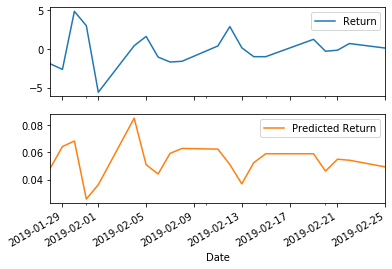

In [41]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(subplots=True)

In [42]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    Results["Return"],
    Results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 1.3720801643019929


In [43]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that DataFrame:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 1.3720801643019929
